In [15]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [16]:
log_dir = "logs"
logs = [f for f in listdir(log_dir) if isfile(join(log_dir, f)) and '.' not in f]

PARENTHESIS_RE = "\((.*)\)"


def read_log(log_file, cut=False):
    with open(join(log_dir, log_file), "r", encoding='latin-1') as f:
        lines = f.readlines()
        params = list(filter(lambda x: "PARAMETERS" in x, lines))
        assert len(params) == 1
        params = params[0].split()[2].split(',')
        params = dict(map(parse_params, params))
        
        losses = list(filter(lambda x: "SUMMARY" in x, lines))
        losses = list(map(read_summary, losses))
        
        events = list(filter(lambda x: "SUMMARY" not in x and "PARAMETERS" not in x, lines))
        events = list(map(read_time, events))
        
        accs = list(filter(lambda x: "ACCURACY" in x, lines))
        #assert len(accs) == 1
        #accs = read_accs(accs[0])
        
        df2 = pd.DataFrame.from_dict(events)
        df = pd.DataFrame.from_dict(losses)
        df = pd.concat([df, df2], sort=False).groupby("epoch").first().reset_index()
        for name, p in params.items():
            df[name] = p
        #for name, p in accs.items():
        #    df[name] = p
        df["end_time"] = (df["end_time"] - df["end_time"].min()) / 1000000000
        df.drop("START_TIME", axis=1, inplace=True)
        if cut:
            th =  df["val_loss"].min() * 1.01
            i = 0
            for idx, rows in df.iterrows():
                if rows["val_loss"] > th:
                    i+=1
            e = df.head(i)["end_time"].min()
            df = df.head(i)
        
        return df
    
def read_accs(line):
    line = line.split()
    accs = re.findall(PARENTHESIS_RE, line[1])[0]
    time = float(line[2])
    acc, pos, neg = (float(i.split("=")[1]) for i in accs.split(","))
    return {"acc": acc, "pos":pos, "neg":neg}
    
def parse_params(param):
    split = param.split("=")
    key = split[0]
    value = split[1]
    try:
        value = int(value)
    except:
        try:
            value = float(value)
        except:
            pass
    return key, value
        
def read_summary(line):
    line = line.split()
    epoch = int(re.findall(PARENTHESIS_RE, line[1])[0])
    losses = re.findall(PARENTHESIS_RE, line[2])[0]
    time = float(line[3])
    train_loss, validation_loss = (float(i.split("=")[1]) for i in losses.split(","))
    return {"epoch": epoch, "end_time": time, "loss": train_loss, "val_loss": validation_loss}

def read_time(line):
    line = line.split()
    epoch = int(re.findall(PARENTHESIS_RE, line[1])[0])
    time = float(line[-1])
    event = line[2]
    return {"epoch": epoch, event + "_TIME": time}
    
    
data = list(map(read_log, logs))
data = reduce(lambda x, y: pd.concat([x,y]), data)
data = data.set_index(["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE", "epoch"])

def plot_all(workers=None, batch_size=None, hist=False):
    fig = plt.figure(figsize=(14,8))
    ax = plt.gca()
    if hist:
        plt.figure(figsize=(14,8))
        ax2 = plt.gca()
    labels = []
    d = data
    title = "Workers/Batch size"
    if workers:
        d = d[np.in1d(d.index.get_level_values(0), [workers])]
        title="Batch Size"
    if batch_size:
        d = d[np.in1d(d.index.get_level_values(1), [batch_size])]
        title="Workers"
    if workers and batch_size:
        title=None
    for idx, df in d.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"]):
        if workers:
            label = "{}".format(idx[1])
        if batch_size:
            label = "{}".format(idx[0])
        if workers and batch_size:
            label = "Workers: {}, Batch size: {}".format(idx[0], idx[1])
        df.plot(x="end_time", y="val_loss", ax=ax, label=label)
        time_diff = (df["end_time"] - df["end_time"].shift(1))
        if hist:
            time_diff.plot(kind='hist', ax=ax2, label=label, bins=200, density=True)
        labels.append(label)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Validation loss")
    ax.legend(labels, title=title)
    fig.savefig("plots/spark_{}_{}.png".format(workers, batch_size), bbox_inches='tight')
    if hist:
        ax2.legend(labels, title=title)
        ax2.set_xlabel("Epoch time (seconds)")
    


In [17]:
def fix_curve(workers, batch, th):
    d = data
    d = d[np.in1d(d.index.get_level_values(0), [workers]) & np.in1d(d.index.get_level_values(1), [batch])]
    s = (d["end_time"] - d["end_time"].shift(1))
    f = s > th
    t = s < th
    m1 = s[f].mean()
    s1 = s[f].std()
    m2 = s[t].mean()
    s2 = s[t].std()
    s[f] = (((s[f] - m1) / s1) * s2) + m2
    data.loc[np.in1d(data.index.get_level_values(0), [workers]) & np.in1d(data.index.get_level_values(1), [batch]),
             ["end_time"]] = s.cumsum()
fix_curve(20, 1024, 30)

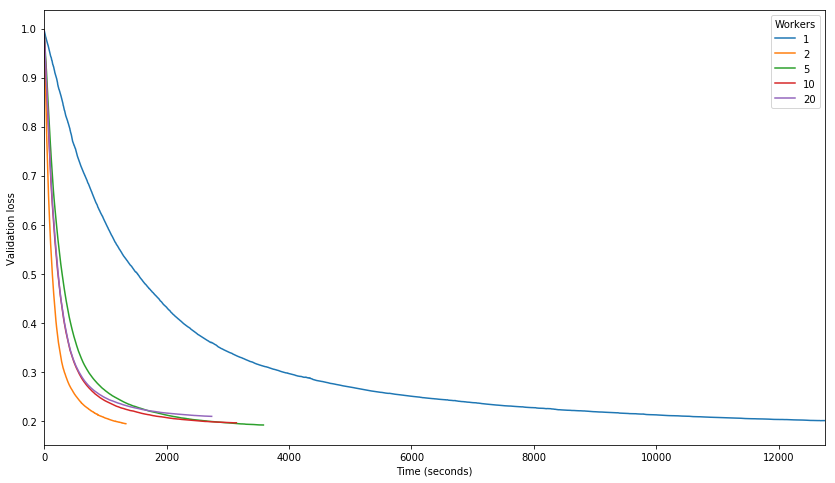

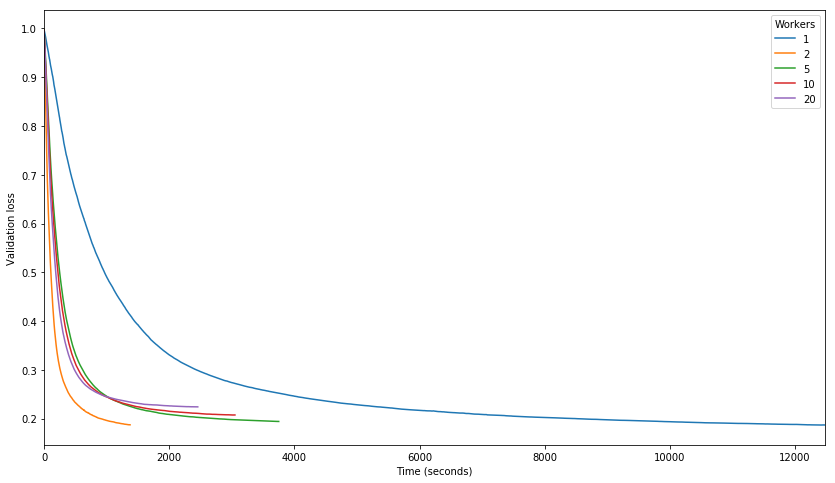

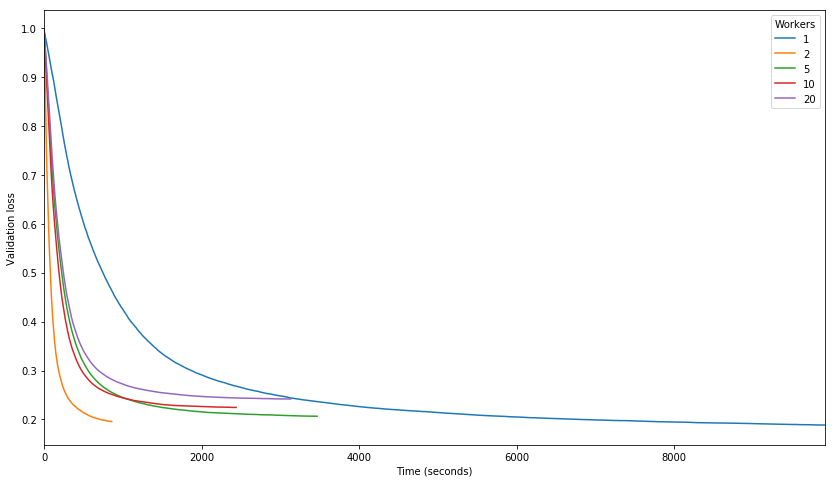

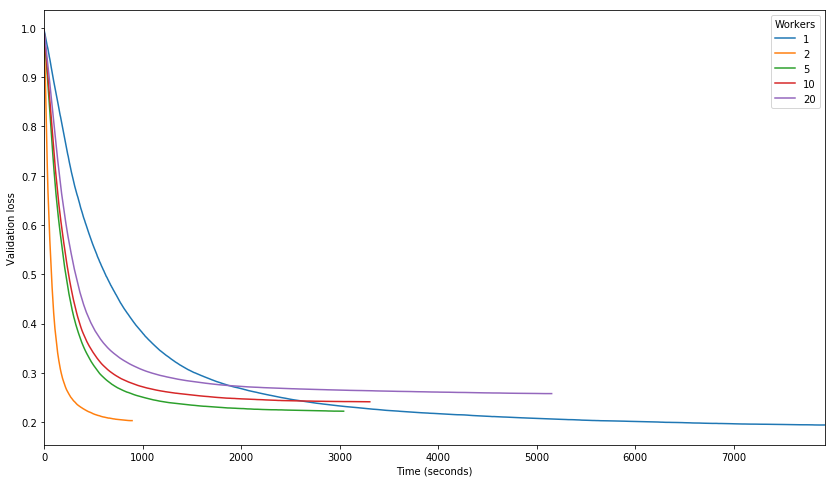

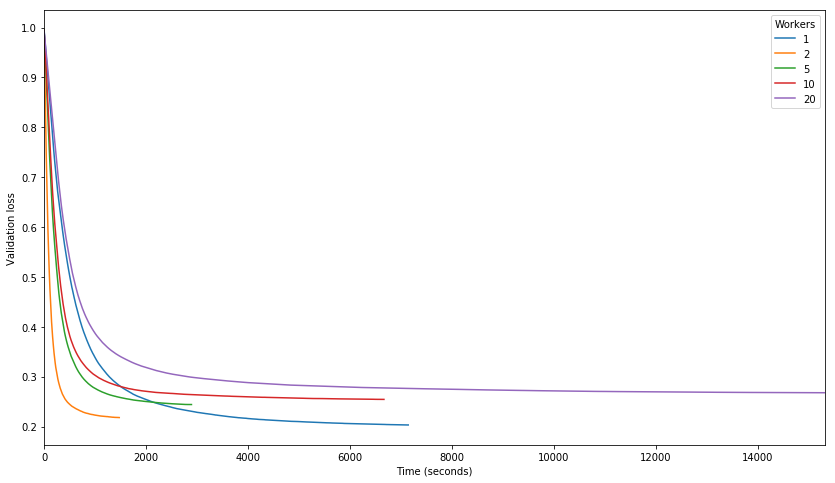

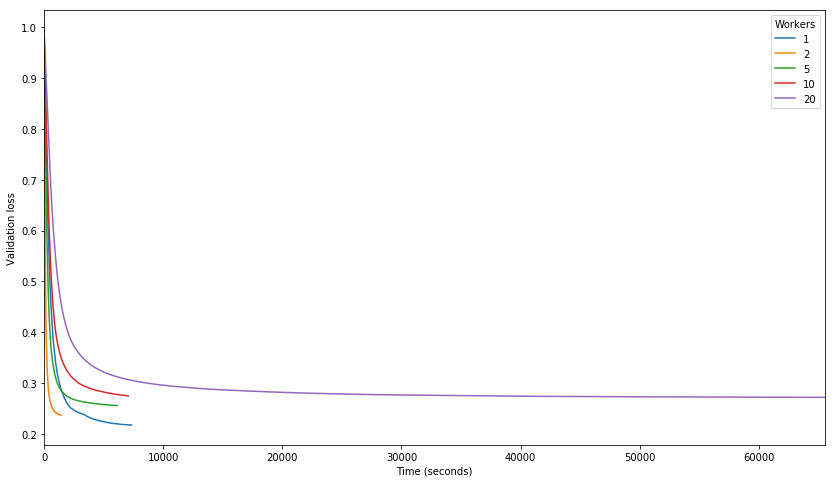

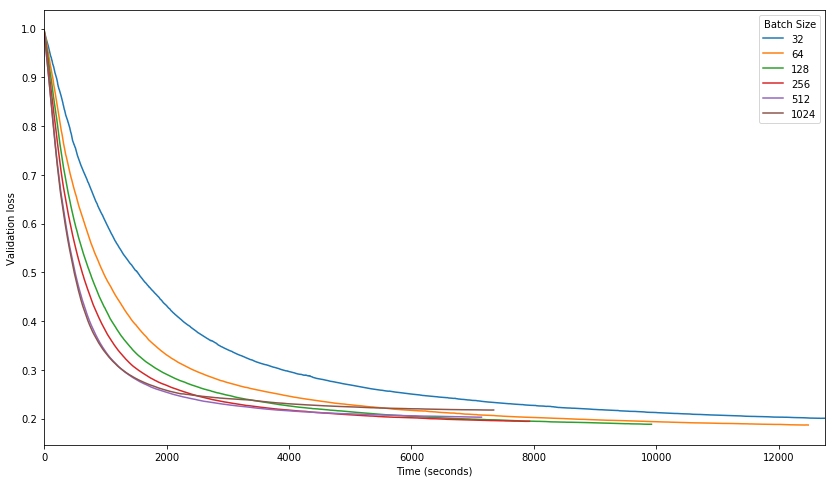

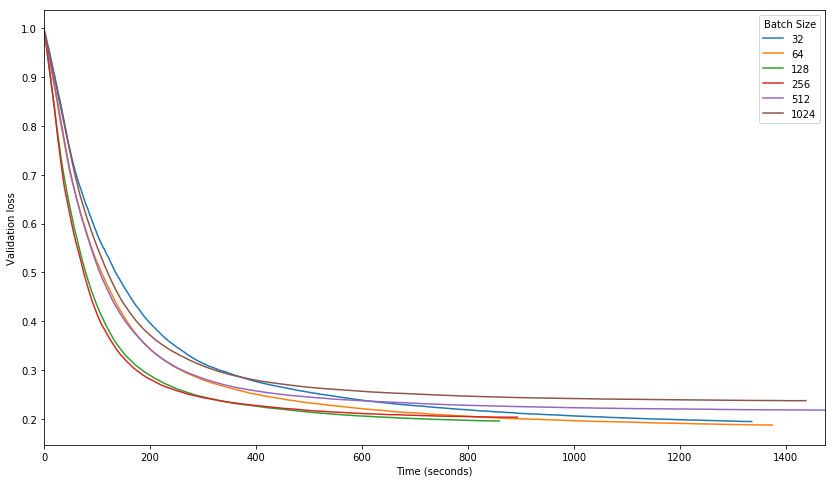

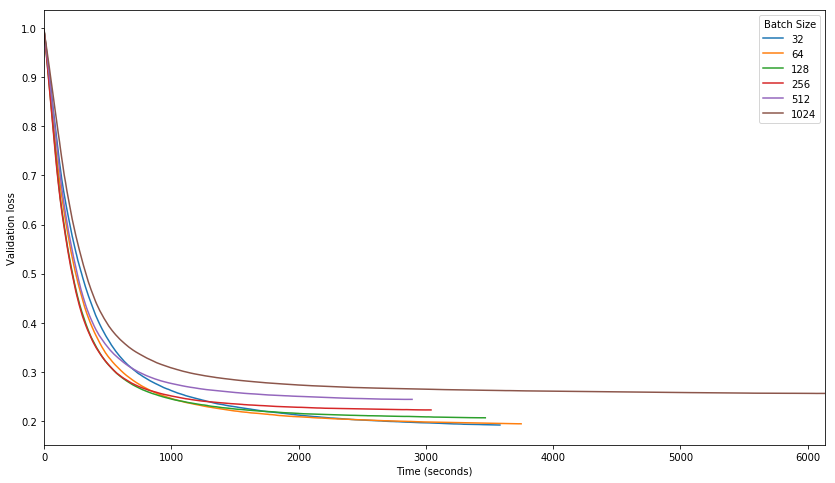

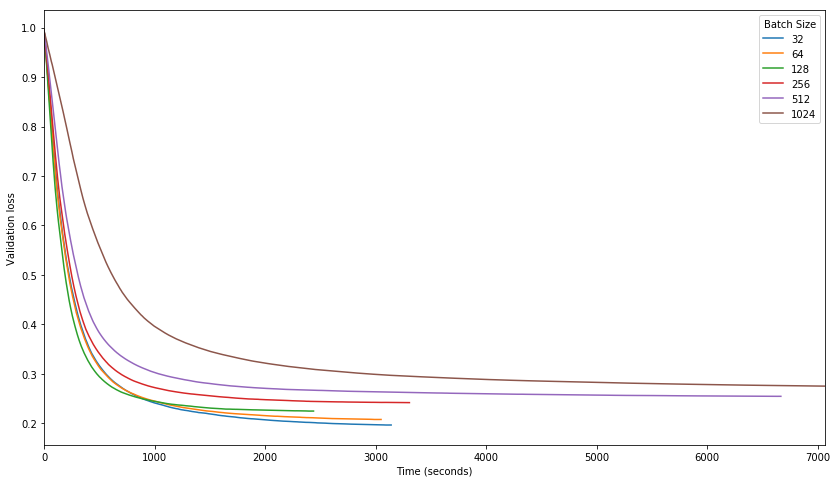

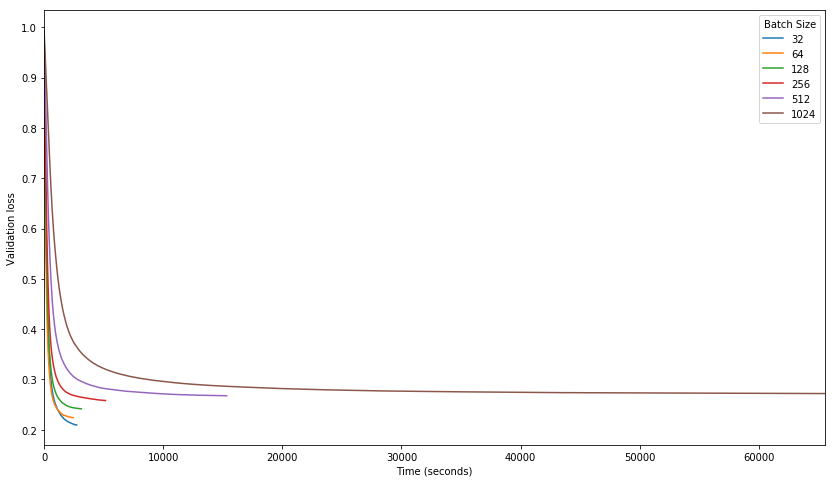

In [18]:
plot_all(batch_size=32)
plot_all(batch_size=64)
plot_all(batch_size=128)
plot_all(batch_size=256)
plot_all(batch_size=512)
plot_all(batch_size=1024)
plot_all(workers=1)
plot_all(workers=2)
plot_all(workers=5)
plot_all(workers=10)
plot_all(workers=20)

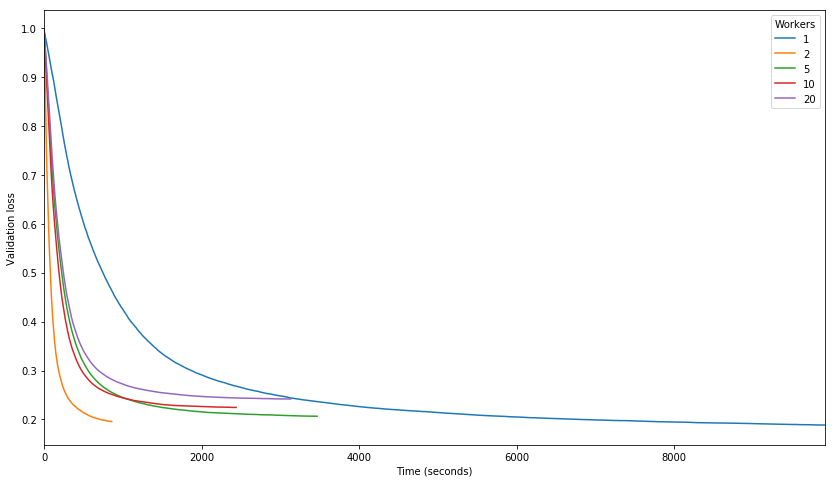

In [12]:
plot_all(batch_size=128)

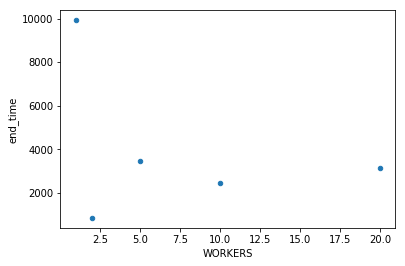

In [13]:
d = data.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"])["end_time"].max()
d = d[np.in1d(d.index.get_level_values(1), [128])].to_frame()
d.reset_index().plot(kind='scatter', x="WORKERS", y="end_time")

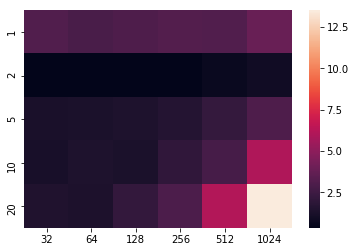

In [19]:
workers_value = sorted(map(int, data.index.levels[0].values))
batch_value = sorted(map(int, data.index.levels[1].values))
times = np.zeros((len(workers_value), len(batch_value)))
workers_idx = {w: i for i, w in enumerate(workers_value)}
batch_idx = {w: i for i, w in enumerate(batch_value)}
for idx, df in data.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"]):
    times[workers_idx[idx[0]], batch_idx[idx[1]]] = (df["end_time"] - df["end_time"].shift(1)).mean()
d = pd.DataFrame(times, columns=batch_idx.keys(), index=workers_idx.keys())
sns.heatmap(d);